In [128]:
# Import required libraries
import matplotlib as mpl
import pathlib
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder

# Set figure parameters
mpl.rc("savefig", dpi=300)
sc.set_figure_params(dpi_save=150, frameon=False, vector_friendly=True,
                     fontsize=6, figsize=(3,3), format='pdf', transparent=True)
pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", 20)
pd.set_option("display.width", 100)

# Style settings
sns.set_style("ticks")
plt.style.use('../bursa.mplstyle')

# File output configurations
output_dir = "../../figures/shared_clones/all_donors"
output_suffix = ""
output_formats = [".png", ".pdf"]
savefig_args = {
    "dpi": 300,
    "bbox_inches": "tight",
    "pad_inches": 0.1,
    "transparent": True,
}
pathlib.Path(output_dir).mkdir(parents=True, exist_ok=True)

# Run helper script
%run ../helper.py


## fxns

In [129]:
def save_figure(
    fig,
    name,
    output_dir=output_dir,
    output_suffix=output_suffix,
    output_formats=output_formats,
    savefig_args=savefig_args,
):
    for output_format in output_formats:
        fig.savefig(
            output_dir + "/" + name + output_suffix + output_format, **savefig_args
        )
    return None

In [130]:
# Function to plot feature importances
def plot_feature_importances(importances, feature_names, title):
    # Sort the features based on their importances
    sorted_indices = np.argsort(importances)[::-1]
    sorted_features = np.array(feature_names)[sorted_indices]
    sorted_importances = importances[sorted_indices]
    
    # Create a DataFrame for easier plotting with Seaborn
    data = pd.DataFrame({'Feature': sorted_features, 'Importance': sorted_importances})
    
    # Initialize the Seaborn plot
    fig, ax = plt.subplots(figsize=(1.25, 4))
    
    # Use Seaborn to plot the bar chart
    sns.barplot(x='Importance', y='Feature', data=data, ax=ax, orient='h', color = 'k')
    ax.tick_params(axis='both', which = 'minor', size = 0)
    # Add labels and title
    plt.xlabel('Importance\n(Regression Coefficient)')
    plt.ylabel('Feature')
    plt.title(title)
    return fig

## load clean and transform data for classifier



In [131]:
# configuration
h5ad = 'all_sharing.h5ad.gz'
#h5ad = 'TBd6_sharing.h5ad.gz'
mb_only = True
as_only = not mb_only
mb_ids = "Memory B|Age-|Prolif"
as_ids = "Plasma"
tissue_relationship = "LN_SP"
use_meta = False
include_non_shared = True
use_filtered = False
gene_feature_sets = [f'{tissue_relationship}/mb_cells_de_genes_true.tab', f'{tissue_relationship}/mb_cells_filtered_de_genes_false.tab', f'{tissue_relationship}/mb_cells_de_genes.tab']
clf_data = "classifier_data.tab"

tissue_combo_to_column = {
    'LN_LN': 'shared_LN_LN',
    'LN_SP': 'shared_LN_SP',
    'LN_PB': 'shared_LN_PB',
    "BM_PB": 'shared_BM_PB',
    "SP_PB": 'shared_SP_PB',
    "SP_BM": 'shared_SP_BM',
    'LN_BM': 'shared_LN_BM',   
    # Add more mappings as needed
}

In [132]:
ad = sc.read_h5ad(h5ad)
if mb_only:
    ad = ad[ad.obs.celltypist.str.contains(mb_ids, regex=True)]
if as_only:
    ad = ad[ad.obs.celltypist.str.contains(as_ids, regex=True)]

In [133]:
# covert probable boolean strings to actual booleans (due to writing strings issue with adata.write_h5ad())
ad.obs = convert_boolean_columns(ad.obs)
# create column for whether any memory B cell is shared between any of the tissue combos
# binarize
ad.obs.shared = ad.obs[f"shared_{tissue_relationship}"]
print(ad.obs.shared.value_counts().xs(True), "shared B cells")
print(ad.obs.shared.value_counts().xs(False), "not shared B cells")
# extract feature set from DEG analysis
use_filtered = False
if use_filtered:
    shared_genes = pd.read_table(gene_feature_sets[1], index_col=0).dropna(subset='names').names[:30]
else:
    shared_genes = pd.read_table(gene_feature_sets[2], index_col=0).dropna(subset = 'names').names[:30]
non_shared_genes = pd.read_table(gene_feature_sets[1], index_col=0).dropna(subset = 'names')['names'].iloc[:15]


if include_non_shared:
    feature_genes = list(shared_genes) + list(non_shared_genes)
else:
    feature_genes = list(shared_genes)

/tmp/ipykernel_123484/2888098616.py:5: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ad.obs.shared = ad.obs[f"shared_{tissue_relationship}"]


2119 shared B cells
73499 not shared B cells


# Set up for building classifier

In [134]:
response_vars = list(tissue_combo_to_column.values())
# add non gene variables to the classifier
if use_meta:
    meta_vars = ['switched', 'v_mismatch', 'celltypist']
else:
    meta_vars = []

In [135]:
features = feature_genes +  meta_vars + response_vars
df = sc.get.obs_df(ad, keys = features)
df.to_csv(clf_data, sep = '\t')

# Classification

/tmp/ipykernel_123484/3167263516.py:2: DtypeWarning: Columns (46) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_table(clf_data)


Random Forest Accuracy: 0.6226415094339622
Random Forest Classification Report:               precision    recall  f1-score   support

       False       0.62      0.61      0.62       422
        True       0.62      0.63      0.63       426

    accuracy                           0.62       848
   macro avg       0.62      0.62      0.62       848
weighted avg       0.62      0.62      0.62       848

Logistic Regression Accuracy: 0.6297169811320755
Logistic Regression Classification Report:               precision    recall  f1-score   support

       False       0.63      0.62      0.62       422
        True       0.63      0.64      0.63       426

    accuracy                           0.63       848
   macro avg       0.63      0.63      0.63       848
weighted avg       0.63      0.63      0.63       848



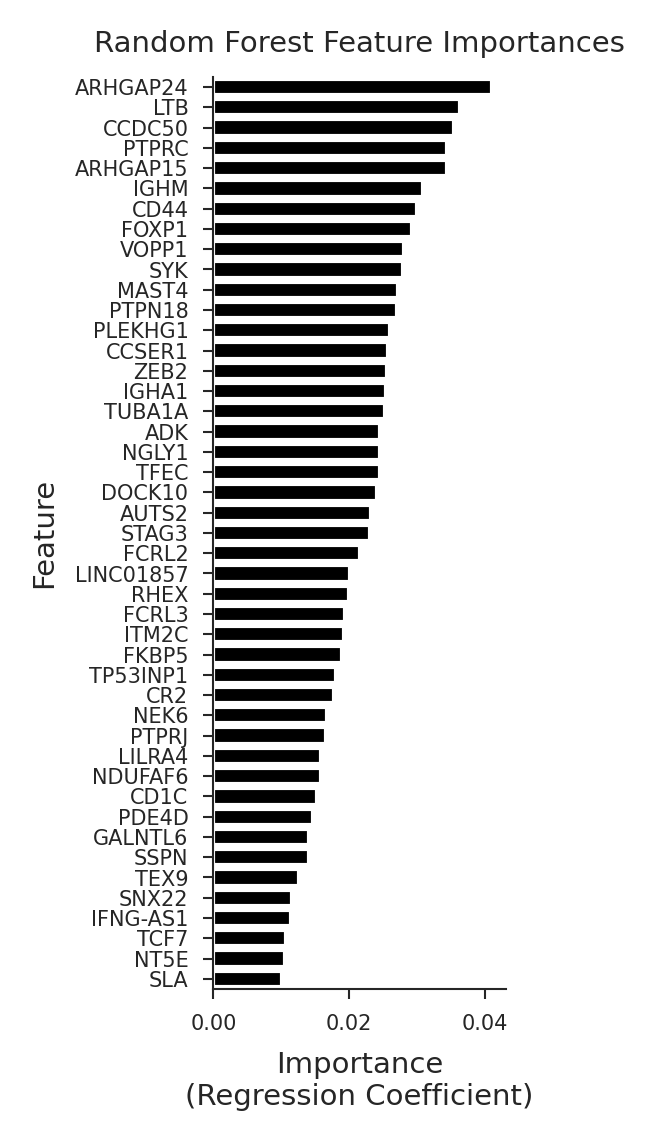

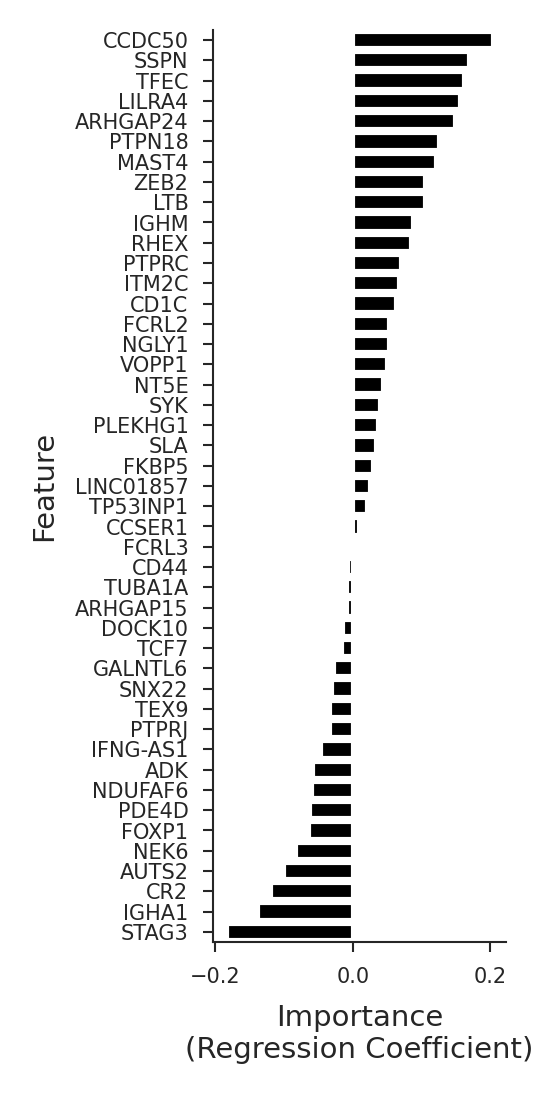

In [136]:
# Load the dataset
df = pd.read_table(clf_data)

# set 'shared' column according to logic
shared_column = f"shared_{tissue_relationship}"
df['shared'] = df[shared_column]
# remove other sharing columns
for val in tissue_combo_to_column.values():
    df.pop(val)

# Drop rows with NaN values in the 'shared' column
df.dropna(subset=['shared'], inplace=True)

# Convert the 'shared' column to integers
df['shared'] = df['shared'].astype(bool)

# Drop index column
df = df.drop(columns=['cb_suid'])

if use_meta:
    # remove celltypist column:
    df.pop('celltypist')
# Label encode 'switched'
    label_encoder = LabelEncoder()
    df['switched'] = label_encoder.fit_transform(df['switched'])
# One-hot encode 'celltypist'
# df = pd.get_dummies(df, columns=['subtype'], drop_first=True)

# Count the number of occurrences of each class
class_counts = df['shared'].value_counts()

# Identify the majority and minority classes
majority_class = class_counts.idxmax()
minority_class = class_counts.idxmin()

# Separate the data by class
df_majority = df[df['shared'] == majority_class]
df_minority = df[df['shared'] == minority_class]

# Undersample the majority class
df_majority_undersampled = df_majority.sample(len(df_minority))

# Concatenate the majority-undersampled and minority dataframes
df_undersampled = pd.concat([df_majority_undersampled, df_minority])

# Shuffle the DataFrame
df_undersampled = df_undersampled.sample(frac=1).reset_index(drop=True)

# Split the dataset into features (X) and target variable (y)
X = df_undersampled.drop('shared', axis=1)
y = df_undersampled['shared']

# Scale the features for clustering and logistic regression
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize and train Random Forest Classifier
rf_clf = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_clf.fit(X_train, y_train)

# Evaluate Random Forest
rf_y_pred = rf_clf.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_y_pred)
rf_classification_rep = classification_report(y_test, rf_y_pred)

# Feature importances for Random Forest
rf_feature_importances = rf_clf.feature_importances_

# Initialize and train Logistic Regression
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)

# Evaluate Logistic Regression
log_y_pred = log_reg.predict(X_test)
log_accuracy = accuracy_score(y_test, log_y_pred)
log_classification_rep = classification_report(y_test, log_y_pred)

# Feature importances for Logistic Regression (coefficients)
log_feature_importances = log_reg.coef_[0]

# Print evaluation metrics
print("Random Forest Accuracy:", rf_accuracy)
print("Random Forest Classification Report:", rf_classification_rep)
print("Logistic Regression Accuracy:", log_accuracy)
print("Logistic Regression Classification Report:", log_classification_rep)

# Plot feature importances
fig1 = plot_feature_importances(rf_feature_importances, X.columns, 'Random Forest Feature Importances')
fig2 = plot_feature_importances(log_feature_importances, X.columns, '')
save_figure(fig2, "LogisticRegression_Feature_Importance")

In [137]:
decision_scores = log_reg.decision_function(X)
plt_df = pd.DataFrame(decision_scores, columns=['lr_score'])
plt_df['shared'] = y

/home/michaelswift/miniconda3/envs/scanpy_new/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


/home/michaelswift/miniconda3/envs/scanpy_new/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


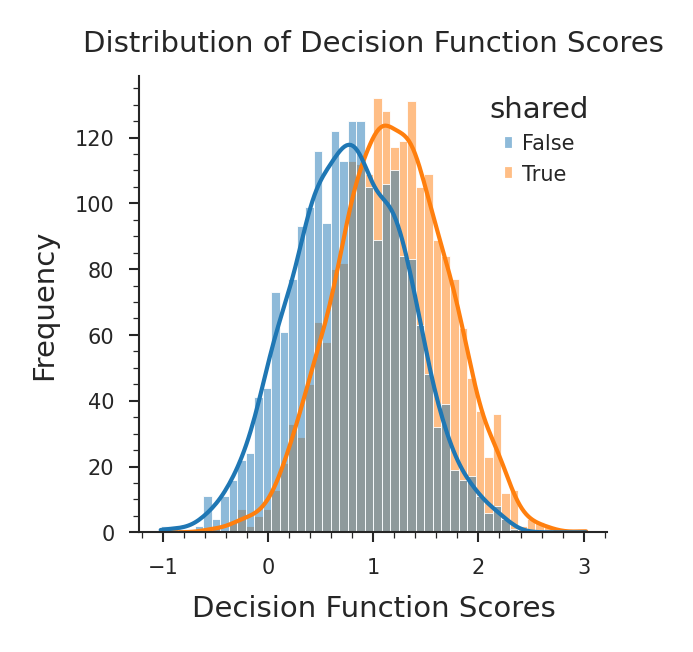

In [138]:
log_probs = log_reg.predict_log_proba(X)
probs = np.exp(log_probs)/(1 + np.exp(log_probs))
probs = probs.T[1]/(probs.T[0]+probs.T[1])
sns.histplot(plt_df, x = plt_df['lr_score'], bins=50, kde=True, hue='shared')
plt.xlabel('Decision Function Scores')
plt.ylabel('Frequency')
plt.title('Distribution of Decision Function Scores')
plt.show()

# Show Decision Function Scores for All Donors, All Tissue Sharing Relationships

In [139]:
df = pd.read_table(clf_data)
df = df.set_index('cb_suid')

/tmp/ipykernel_123484/640810673.py:1: DtypeWarning: Columns (46) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_table(clf_data)


In [140]:
X_index = len(tissue_combo_to_column) + len(meta_vars)

In [141]:
X = df.iloc[:,:-X_index].values
# calculate decision scores for all Memory Cells
# this will break in the include meta_vars case
decision_scores = log_reg.decision_function(X)
df['decision_scores'] = decision_scores
df.to_csv("data.csv")

/tmp/ipykernel_123484/356301322.py:2: DtypeWarning: Columns (46) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data.csv", index_col=0)


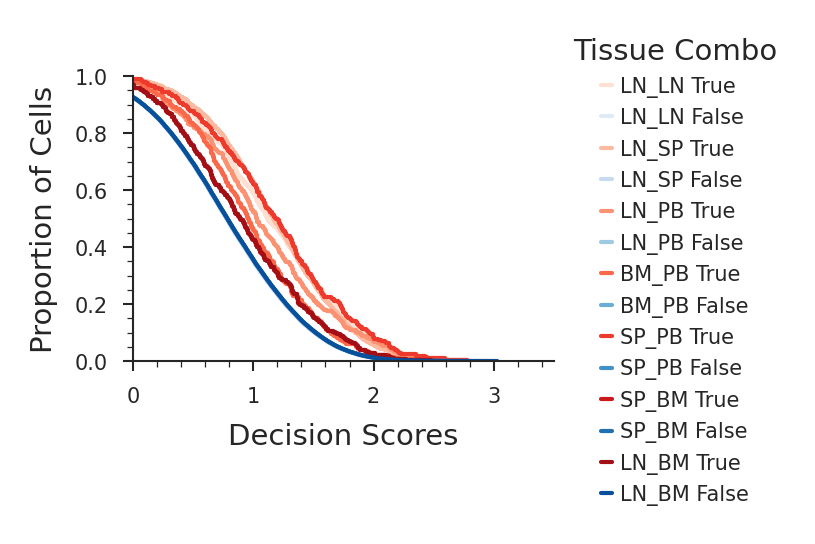

In [142]:


# Read the CSV file into a DataFrame
df = pd.read_csv("data.csv", index_col=0)

# Handle NaN values by setting them to False
df.fillna({col: False for col in df.filter(like='shared_').columns}, inplace=True)

# Define the tissue_combo_to_column dictionary for renaming legend labels
tissue_combo_to_column = {
    'LN_LN': 'shared_LN_LN',
    'LN_SP': 'shared_LN_SP',
    'LN_PB': 'shared_LN_PB',
    'SP_PB' : 'shared_SP_PB',
    "BM_PB": 'shared_BM_PB',
    "SP_BM" : 'shared_SP_BM',
    "LN_BM" : 'shared_LN_BM'
    # Add more mappings as needed
}

# Initialize empty dictionary to store color mapping
color_mapping = {}

# Define shades of red and blue for True and False values
shades_of_red = sns.color_palette("Reds", n_colors=len(df.filter(like='shared_').columns))
shades_of_blue = sns.color_palette("Blues", n_colors=len(df.filter(like='shared_').columns))

fig, ax = plt.subplots(1,1, figsize = (1.8, 1.25))

# Loop over each tissue_combo (shared column) to plot
for idx, tissue_combo in enumerate(df.filter(like='shared_').columns):
    # Extract human-readable label from the dictionary if available
    human_readable_label = [k for k, v in tissue_combo_to_column.items() if v == tissue_combo]
    human_readable_label = human_readable_label[0] if human_readable_label else tissue_combo
    
    # Extract data for the current tissue_combo where the value is True
    tissue_df = df[df[tissue_combo]]
    
    # Plot the ECDF for True values in this tissue_combo
    sns.ecdfplot(data=tissue_df, x='decision_scores', complementary=True, 
                 color=shades_of_red[idx], label=f"{human_readable_label} True")
    
    # Extract data for the current tissue_combo where the value is False
    tissue_df = df[~df[tissue_combo]]
    
    # Plot the ECDF for False values in this tissue_combo
    sns.ecdfplot(data=tissue_df, x='decision_scores', complementary=True, 
                 color=shades_of_blue[idx], label=f"{human_readable_label} False")
# Add legend to the plot
ax.legend(title='Tissue Combo', bbox_to_anchor=(1, 1.2), loc='upper left')
ax.set_xlabel("Decision Scores")
ax.set_ylabel("Proportion of Cells")
ax.set_xlim(0,3.5)
# Show the plot
plt.show()
save_figure(fig, "ecdf_logreg_scores")